# **1 - Clustering: Balearic SurveyPoints**

##### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import DBSCAN

# Read data

##### Project main path

In [2]:
# Change path so that it points to  were data is located
pth = Path(r'..\data')
pth

WindowsPath('../data')

### Read Balearic survey data
This csv file contains the identifier of each survey point and its easting and northing. It also contains the presence ceramic types at each point. This file has been generated after selecting those survey points with diagnostic wares for the Balearic period.

In [3]:
fn =pth / 'artifacts' / 'by_pts' / 'balearic_presence_types.txt'
data= pd.read_csv(fn, index_col= ['SurveyPointId', 'Easting', 'Northing'])
data.shape

(832, 4)

In [4]:
data.head(10)

,,,Amphora,Coarseware,Commonware,Fineware
SurveyPointId,Easting,Northing,,,,
02001d-77-012,531989.73,4385614.15,1.0,0.0,0.0,0.0
02001d-80-008,531872.15,4385569.72,1.0,0.0,0.0,0.0
02001d-82-024,532116.88,4385546.76,1.0,0.0,0.0,0.0
021540-83-107,532127.62,4385358.91,0.0,1.0,0.0,0.0
021540-84-208,532164.35,4385338.75,1.0,0.0,0.0,0.0
021540-85-408,532151.02,4385346.02,1.0,0.0,0.0,0.0
03039b-14-311,532676.30,4385941.44,0.0,1.0,0.0,0.0
03039b-14-312,532663.24,4385944.05,0.0,1.0,1.0,0.0
03039b-44-318,532729.52,4385777.52,1.0,0.0,0.0,0.0


# Spatial Clustering

We shall group survey points using **DBSCAN** clustering method using euclidean distance as our metric


##### Extract location 

In [5]:
loc = data.reset_index()[['Northing', 'Easting']].to_numpy()

##### Find nearest neighbors for each point to its closest 10 points

In [6]:
from sklearn.neighbors import NearestNeighbors

# find nearest 10 neighbors
nmax = 10
neighs = NearestNeighbors(n_neighbors = nmax)
neighs_fit = neighs.fit(loc)
distances, indices = neighs_fit.kneighbors(loc)

#### Find cutoff distance
We are going to consider that a minimum cluster should be made by at least 4 survey points. In order to determine the distance given this minimum number of survey points, we plot all the distances to the fourth nearest neighbor and select the distance  at which the rate of change is the largest. Changes between neighbors can be very drastic (especially at a local level) but we are interested in the distance where the more global qualitative changes occur. In order to obtain this value, we first smooth our distances so that can better determine where change is largest overall.

In [7]:
from kneed import KneeLocator
from  scipy.signal import savgol_filter
n = 4-1
y  = np.sort(distances, axis=0)[:,n]
x = np.arange(y.size)
kneedle = KneeLocator(x,savgol_filter(y, 21, 3), curve='convex', direction='increasing')
print(f'Knee occurs at x= {kneedle.knee} and y= {y[kneedle.knee]:.2f}')

Knee occurs at x= 719 and y= 61.07


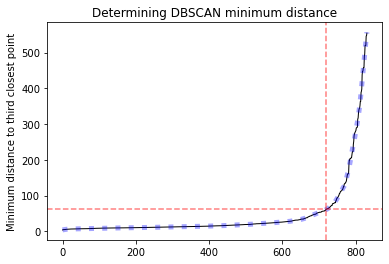

In [8]:
# plot our results

fig, ax = plt.subplots()
ax.plot(x, y, c='k', linewidth=1)
ax.plot(x, savgol_filter(y, 31, 3), c='blue', linestyle=':', linewidth=5, alpha=0.35)
ax.axhline(y=y[kneedle.knee], c='red', alpha=0.5, linestyle='--')
ax.axvline(x=kneedle.knee, c='red', alpha=0.5, linestyle='--')
ax.set_ylabel('Minimum distance to third closest point')
ax.set_title('Determining DBSCAN minimum distance');

### Run dbscan

In [9]:
db_scan = DBSCAN(eps= 61.07, min_samples=4) 
db_scan.fit(loc)

DBSCAN(eps=61.07, min_samples=4)

In [10]:
# Generate a column for each survey point with the label of the cluster the point belongs to.
data['dbscan'] = db_scan.labels_

##### Save Clustered Survey Points

In [11]:
fn = pth / 'clustered' / 'spatial' / 'cluster_pts.txt'

# Uncomment and change path above to save clustered points
#data.to_csv(fn)